# Bayes-by-backprop
## 1D regression

In [3]:
import jax
import optax
import distrax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from chex import dataclass
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from jaxtyping import Float, Array
from flax.training.train_state import TrainState

from dynamax.utils import datasets
from dynamax.rebayes import bayes_by_backprop as bbb

In [4]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

## Load dataset

In [5]:
train, test = datasets.load_1d_synthetic_dataset(200, 400)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

X_test = (X_test - X_test.mean()) / X_test.std()
y_test = (y_test - y_test.mean()) / y_test.std()

X_train = X_test[:200]
y_train = y_test[:200]

X_test = X_test[200:]
y_test = y_test[200:]

In [67]:
y_test.shape

(200, 1)

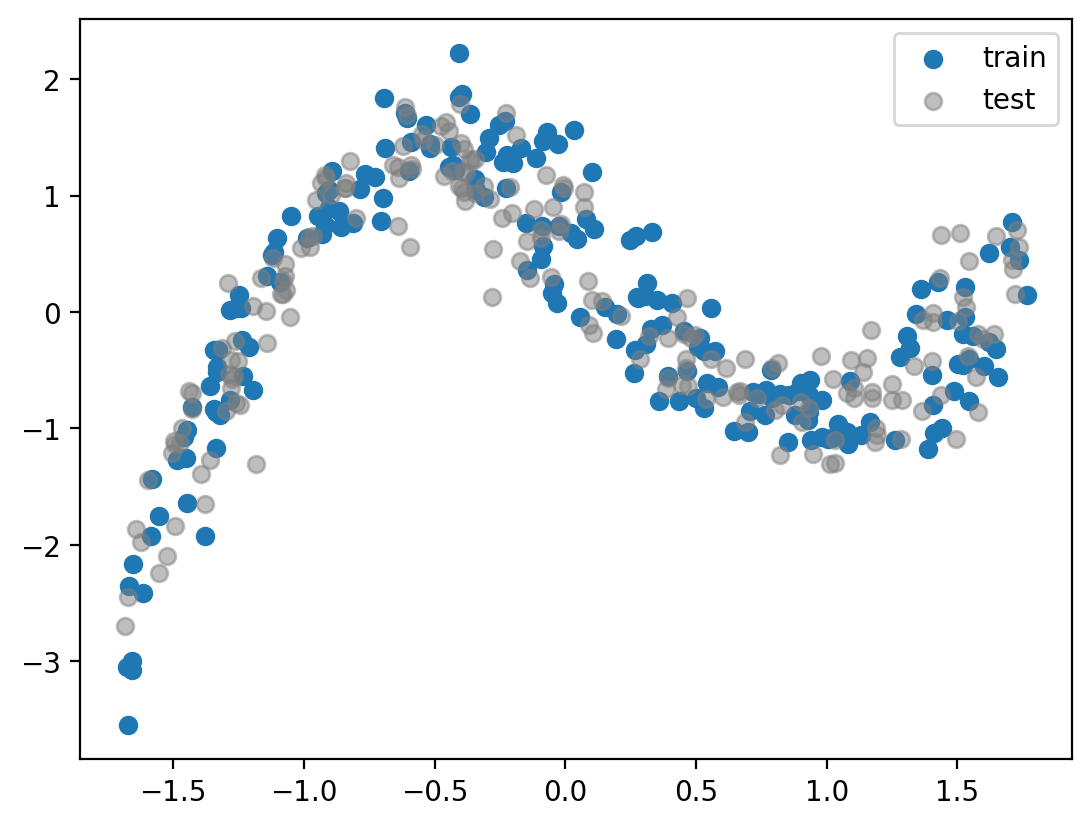

In [6]:
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, c="tab:gray", label="test", alpha=0.5, )
plt.legend()

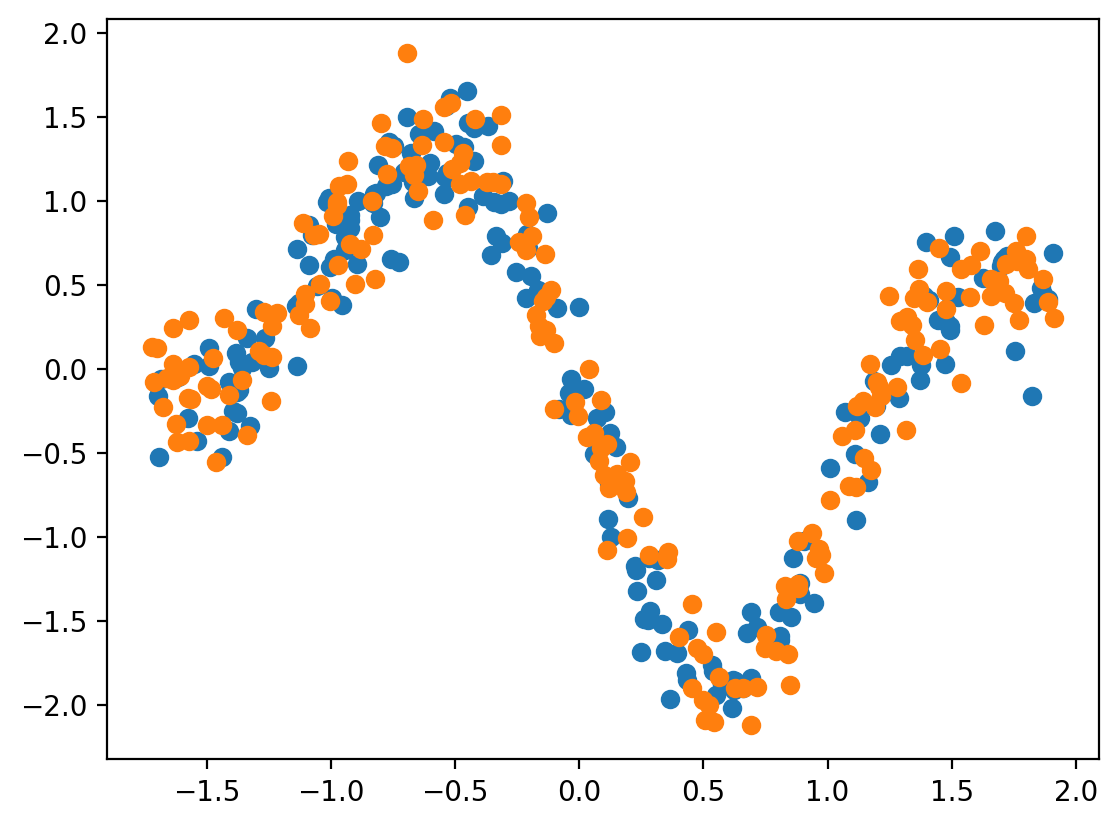

In [115]:
import GPy
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())

ixs = np.random.choice(no_points, no_points, replace=False)
x = x[ixs]
y = y[ixs]


x_train = x[:200]
y_train = y[:200]

x_test = x[200:]
y_test = y[200:]

x_mean, x_std = x_train.mean(), x_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

X_test = (x_test - x_mean) / x_std
y_test = (y_test - y_mean) / y_std

X_train = jnp.array(X_train)
y_train = jnp.array(y_train).ravel()

X_test = jnp.array(X_test)
y_test = jnp.array(y_test).ravel()


plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

### Linked

In [696]:
@dataclass
class PriorParam:
    scale_obs: float
    scale_weight: float

def cost_fn(
    key: jax.random.PRNGKey,
    state: bbb.BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam,
    rbnn_scale: float
):
    """
    TODO:
    * Add more general way to compute observation-model log-probability
    * Add scale for r as an optional parameter
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    # Sampled params
    params = bbb.sample_rbnn_params(key, state, reconstruct_fn, scale=rbnn_scale)
    params_flat = bbb.get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()

    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, rho, x: distrax.Normal(loc=mean, scale=jnp.log(1 + jnp.exp(rho))).log_prob(x),
        state.mean, state.rho, params
    )
    logp_variational = bbb.get_leaves(logp_variational).sum()
    
    num_obs = len(y)
    loss = (logp_variational - logp_prior) / 17 - logp_obs
    return loss


def lossfn(key, params, X, y, model, reconstruct_fn, priors, rbnn_scale, num_samples=30):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, reconstruct_fn, model, priors, rbnn_scale).mean()
    return loss


@partial(jax.jit, static_argnames=("reconstruct_fn", "rbnn_scale"))
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def sample_and_eval(key, state, X, reconstruct_fn, rbnn_scale):
    params_sample = bbb.sample_rbnn_params(key, state, reconstruct_fn, scale=rbnn_scale)
    return model.apply(params_sample, X)


@partial(jax.jit, static_argnames=("reconstruct_fn", "rbnn_scale", "num_samples"))
def eval_mae(key, params, X, y, reconstruct_fn, rbnn_scale, num_samples=20):
    keys_sample = jax.random.split(key, num_samples)
    yhat_samples = sample_and_eval(keys_sample, params, X, reconstruct_fn, rbnn_scale).squeeze()
    yhat = yhat_samples.mean(axis=0)
    err_pp = y - yhat
    return jnp.abs(err_pp).mean(), yhat

## Model setup

In [682]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

In [683]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [684]:
dim_input = 1
batch_size = 15
batch = (batch_size, dim_input)
model = MLP(1, dim_hidden=150, activation=nn.elu)
batch = jnp.ones(batch)

In [685]:
num_epochs = 2000
tx = optax.adam(1e-5)
rbnn_scale = 5.0
keys_epochs = jax.random.split(key_train, num_epochs)

priors = PriorParam(scale_obs=1.0, scale_weight=1.0)
part_lossfn = partial(lossfn, priors=priors, rbnn_scale=rbnn_scale)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = bbb.init_bbb_params(key_init, model, batch)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)

Text(0.5, 1.0, 'BNN Gauss — prior samples')

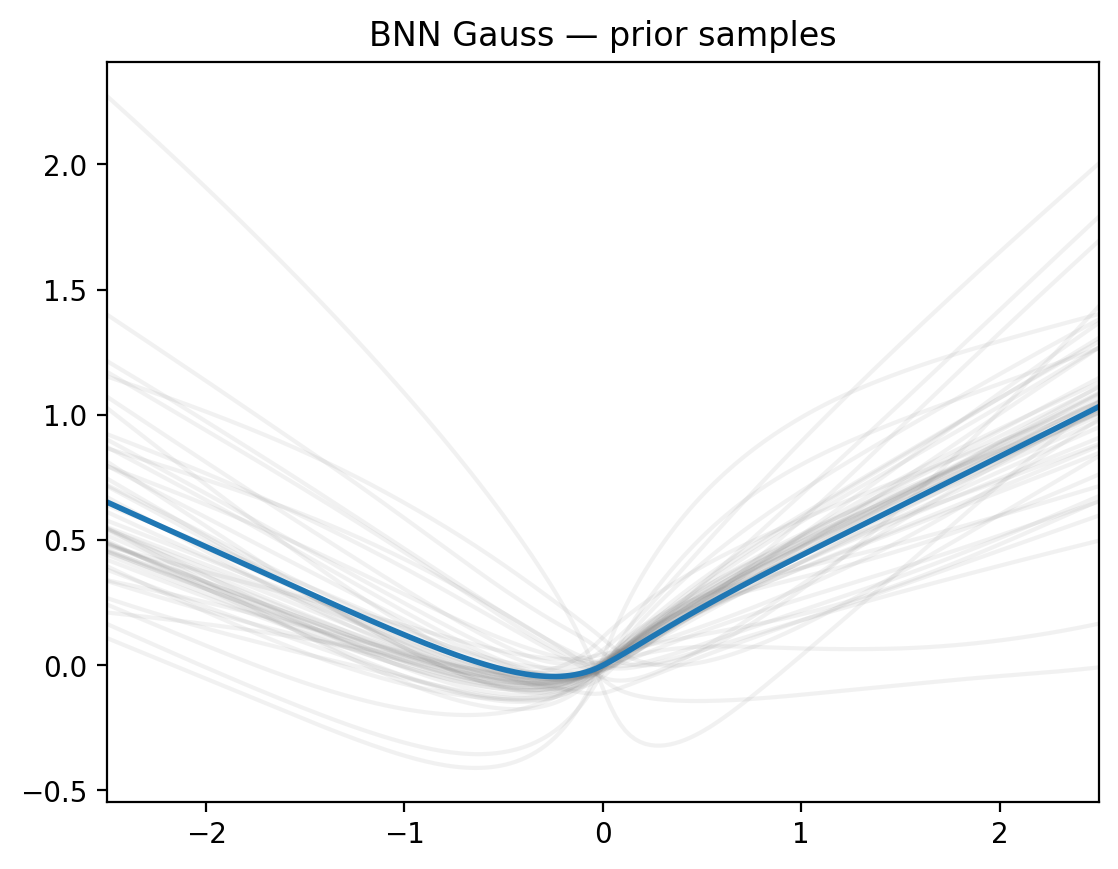

In [686]:
xmin, xmax = -2.5, 2.5
x_eval = jnp.linspace(xmin, xmax, 200)
keys_eval = jax.random.split(key_train, 50)
yhat_prior = sample_and_eval(keys_eval, b3p, x_eval[:, None], reconstruct_fn, rbnn_scale).squeeze()

for sample in yhat_prior:
    plt.plot(x_eval, sample, c="tab:gray", alpha=0.1)
plt.plot(x_eval, yhat_prior.mean(axis=0), c="tab:blue", linewidth=2)
plt.xlim(xmin, xmax)
plt.title("BNN Gauss — prior samples")

In [698]:
%%time
losses = []
test_mae = []
train_mae = []

for epoch in (pbar := tqdm(range(num_epochs))):
    key_epoch = jax.random.fold_in(key_train, epoch)
    loss, opt_state = bbb.train_epoch(key_epoch, opt_state, X_train, y_train, batch_size, part_lossfn, model, reconstruct_fn)
    
    mae_train, _ = eval_mae(key, opt_state.params, X_train, y_train, reconstruct_fn, rbnn_scale)
    mae_test, _ =  eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn, rbnn_scale)
    test_mae.append(mae_test)
    train_mae.append(mae_train)

    
    pbar.set_description(f"{loss=:0.4e} | {mae_train=:0.4f} | {mae_test=:0.4f}")
    losses.append(loss)
    
losses = np.array(losses)
test_mae = np.array(test_mae)
train_mae = np.array(train_mae)

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 57.6 s, sys: 9.45 s, total: 1min 7s
Wall time: 2min 8s


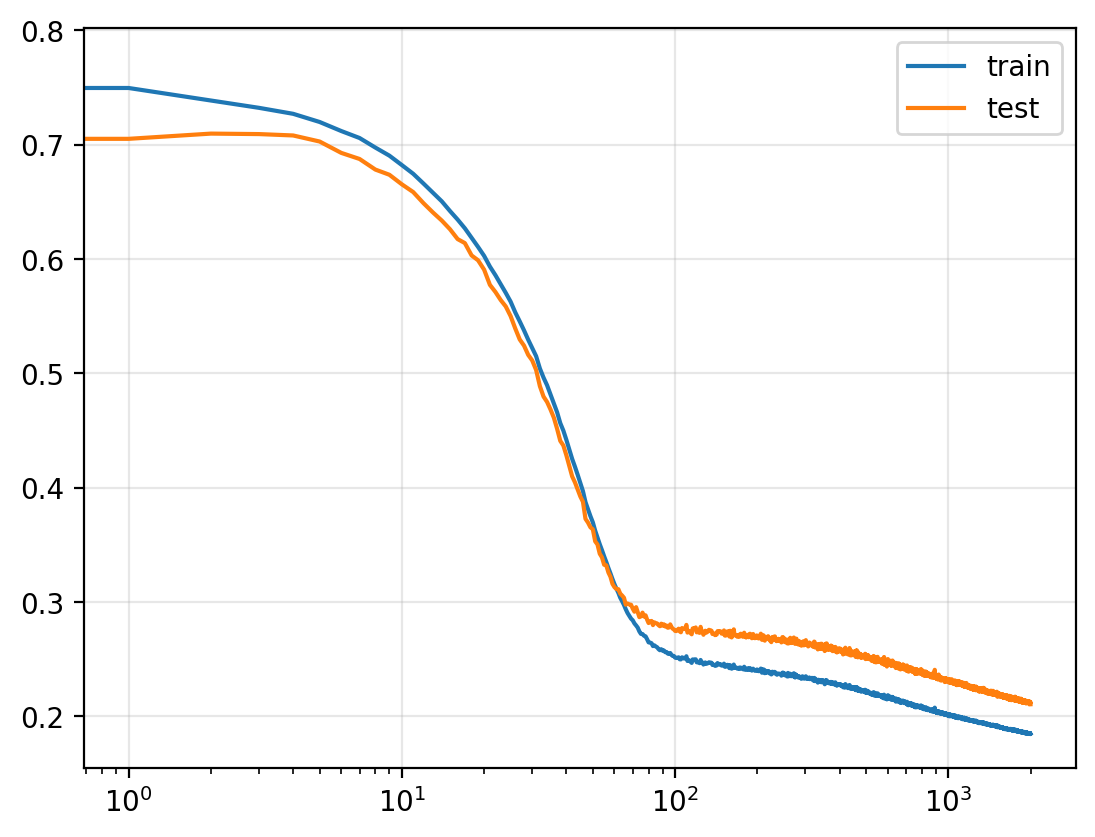

In [699]:
plt.plot(train_mae, label="train")
plt.plot(test_mae, label="test")
plt.legend()
plt.xscale("log")
plt.grid(alpha=0.3)




## Model evaluation

In [702]:
mae, yhat_test = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn, rbnn_scale, num_samples=20)
mae

DeviceArray(0.21041477, dtype=float32)

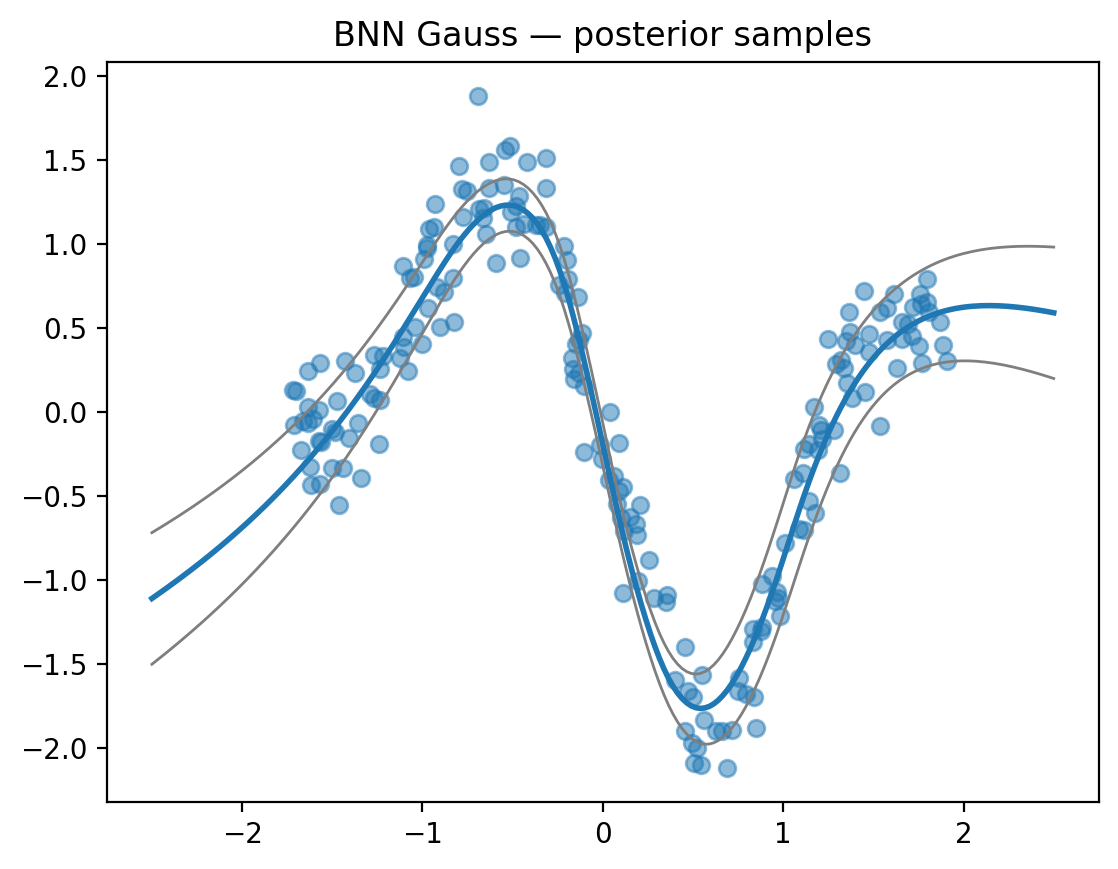

In [703]:
x_eval = jnp.linspace(-2.5, 2.5, 200)
keys_eval = jax.random.split(key_train, 100)
yhat_samples = sample_and_eval(keys_eval, opt_state.params, x_eval[:, None], reconstruct_fn, rbnn_scale).squeeze()

yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)
# for sample in yhat_samples:
#     plt.plot(x_eval, sample, c="tab:gray", alpha=0.2)
plt.plot(x_eval, yhat_mean, c="tab:blue", linewidth=2)
plt.plot(x_eval, yhat_mean + 2 * yhat_std, c="tab:gray", linewidth=1)
plt.plot(x_eval, yhat_mean - 2 * yhat_std, c="tab:gray", linewidth=1)
plt.scatter(X_test, y_test, alpha=0.5)
plt.title("BNN Gauss — posterior samples");

In [ ]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

## In-betwee uncertainty